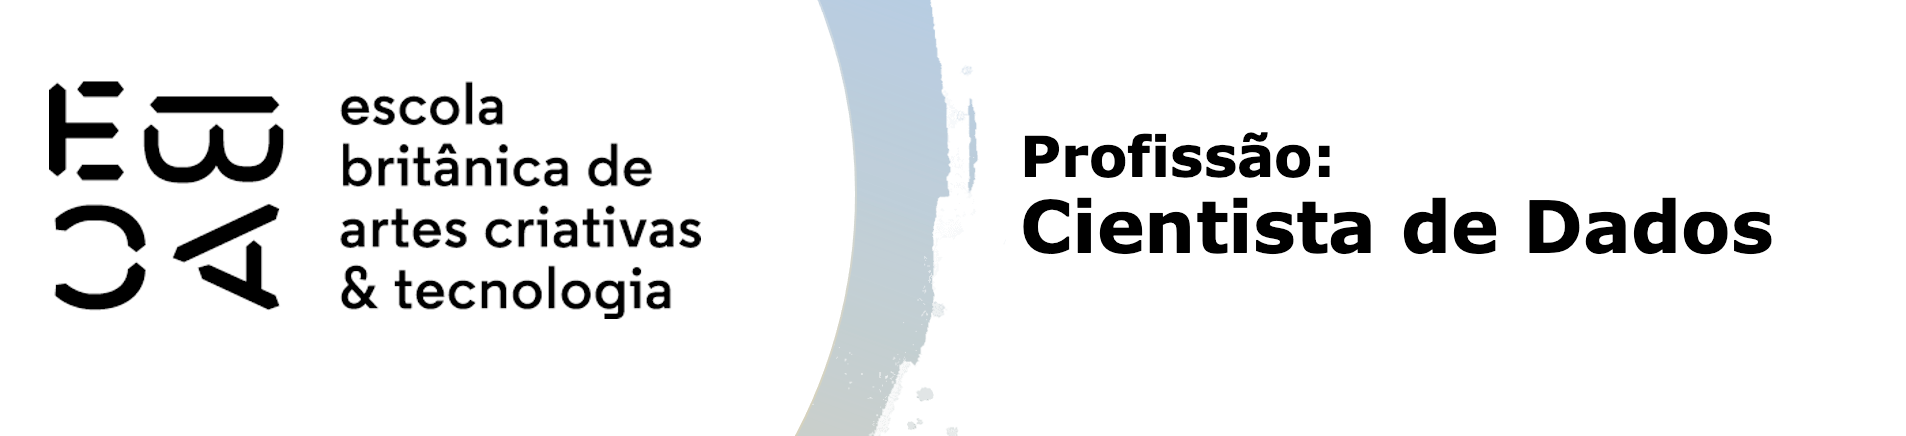

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [42]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import pickle

In [3]:
df_raw = pd.read_feather('data/credit_scoring.ftr')
df_raw.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
df_oot = df_raw[df_raw['data_ref'] >= (df_raw['data_ref'].max() - pd.DateOffset(months=3))].copy()
df_train = df_raw[df_raw['data_ref'] < (df_raw['data_ref'].max() - pd.DateOffset(months=3))].copy()

In [5]:
#tratando variáveis
df_train = df_train.drop(columns=['index', 'data_ref'])
df_train = df_train.drop_duplicates()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137971 entries, 0 to 549973
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   137971 non-null  object 
 1   posse_de_veiculo       137971 non-null  object 
 2   posse_de_imovel        137971 non-null  object 
 3   qtd_filhos             137971 non-null  int64  
 4   tipo_renda             137971 non-null  object 
 5   educacao               137971 non-null  object 
 6   estado_civil           137971 non-null  object 
 7   tipo_residencia        137971 non-null  object 
 8   idade                  137971 non-null  int64  
 9   tempo_emprego          114482 non-null  float64
 10  qt_pessoas_residencia  137971 non-null  float64
 11  renda                  137971 non-null  float64
 12  mau                    137971 non-null  bool   
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 13.8+ MB


In [7]:
df_train_X = df_train.drop(columns=['mau'])
df_train_y = df_train['mau']

In [8]:
cols_num = df_train_X.select_dtypes(include=['int', 'float']).columns.tolist()
cols_cat = df_train_X.select_dtypes(exclude=['int', 'float']).columns.tolist()

In [9]:
one_hot = OneHotEncoder(sparse_output=False, drop="first").set_output(transform="pandas")
df_train_X_cat = one_hot.fit_transform(df_train_X[cols_cat])

In [10]:
df_train_X = pd.concat([df_train_X_cat, df_train_X[cols_num]], axis=1)

In [11]:
df_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137971 entries, 0 to 549973
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   sexo_M                         137971 non-null  float64
 1   posse_de_veiculo_S             137971 non-null  float64
 2   posse_de_imovel_S              137971 non-null  float64
 3   tipo_renda_Bolsista            137971 non-null  float64
 4   tipo_renda_Empresário          137971 non-null  float64
 5   tipo_renda_Pensionista         137971 non-null  float64
 6   tipo_renda_Servidor público    137971 non-null  float64
 7   educacao_Médio                 137971 non-null  float64
 8   educacao_Pós graduação         137971 non-null  float64
 9   educacao_Superior completo     137971 non-null  float64
 10  educacao_Superior incompleto   137971 non-null  float64
 11  estado_civil_Separado          137971 non-null  float64
 12  estado_civil_Solteiro         

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [12]:
df_train_X.isnull().sum()

sexo_M                               0
posse_de_veiculo_S                   0
posse_de_imovel_S                    0
tipo_renda_Bolsista                  0
tipo_renda_Empresário                0
tipo_renda_Pensionista               0
tipo_renda_Servidor público          0
educacao_Médio                       0
educacao_Pós graduação               0
educacao_Superior completo           0
educacao_Superior incompleto         0
estado_civil_Separado                0
estado_civil_Solteiro                0
estado_civil_União                   0
estado_civil_Viúvo                   0
tipo_residencia_Casa                 0
tipo_residencia_Com os pais          0
tipo_residencia_Comunitário          0
tipo_residencia_Estúdio              0
tipo_residencia_Governamental        0
qtd_filhos                           0
idade                                0
tempo_emprego                    23489
qt_pessoas_residencia                0
renda                                0
dtype: int64

In [13]:
si = SimpleImputer(strategy='constant', fill_value=0).set_output(transform="pandas")
df_train_X = si.fit_transform(df_train_X)

In [14]:
df_train_X.isnull().sum()

sexo_M                           0
posse_de_veiculo_S               0
posse_de_imovel_S                0
tipo_renda_Bolsista              0
tipo_renda_Empresário            0
tipo_renda_Pensionista           0
tipo_renda_Servidor público      0
educacao_Médio                   0
educacao_Pós graduação           0
educacao_Superior completo       0
educacao_Superior incompleto     0
estado_civil_Separado            0
estado_civil_Solteiro            0
estado_civil_União               0
estado_civil_Viúvo               0
tipo_residencia_Casa             0
tipo_residencia_Com os pais      0
tipo_residencia_Comunitário      0
tipo_residencia_Estúdio          0
tipo_residencia_Governamental    0
qtd_filhos                       0
idade                            0
tempo_emprego                    0
qt_pessoas_residencia            0
renda                            0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [15]:
def IQR_Outliers(X, features, multiplier = 1):

    print('# of features: ', len(features))
    print('Features: ', features)

    indices = [x for x in X.index]
    #print(indices)
    print('Number of samples: ', len(indices))
    
    out_indexlist = []
        
    for col in features:
       
        #Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(X[col], 25.)
        Q3 = np.nanpercentile(X[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = (Q3 + cut_off)*multiplier, (Q1 - cut_off)
        print ('\nFeature: ', col)
        print ('Upper and Lower limits: ', upper, lower)
                
        outliers_index = X[col][(X[col] < lower) | (X[col] > upper)].index.tolist()
        outliers = X[col][(X[col] < lower) | (X[col] > upper)].values
        print('Number of outliers: ', len(outliers))
        if len(outliers) > 0:
            print('Outliers Min: ', min(outliers))
            print('Outliers Max: ', max(outliers))
        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    print('\nNumber of rows with outliers: ', len(out_indexlist))

    return out_indexlist

In [16]:
index_outlier = IQR_Outliers(df_train_X, cols_num, 4)

# of features:  5
Features:  ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Number of samples:  137971

Feature:  qtd_filhos
Upper and Lower limits:  10.0 -1.5
Number of outliers:  18
Outliers Min:  14.0
Outliers Max:  14.0

Feature:  idade
Upper and Lower limits:  326.0 5.5
Number of outliers:  0

Feature:  tempo_emprego
Upper and Lower limits:  78.87671232876713 -10.078082191780823
Number of outliers:  0

Feature:  qt_pessoas_residencia
Upper and Lower limits:  18.0 0.5
Number of outliers:  0

Feature:  renda
Upper and Lower limits:  167868.34000000003 -18930.715000000004
Number of outliers:  2813
Outliers Min:  167930.38
Outliers Max:  4083986.22

Number of rows with outliers:  2831


In [17]:
#removendo Outliers
df_train_X = df_train_X.loc[np.setdiff1d(df_train_X.index,index_outlier)].copy()
df_train_y = df_train_y.loc[np.setdiff1d(df_train_y.index,index_outlier)].copy()

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(df_train_X, df_train_y)

RandomForestClassifier(random_state=42)

In [19]:
feature_importances = clf.feature_importances_

In [20]:
selected_features_indices = np.where(feature_importances > 0.01)[0]
selected_features = df_train_X.columns[selected_features_indices]

In [21]:
selected_features

Index(['posse_de_veiculo_S', 'qtd_filhos', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'renda'],
      dtype='object')

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [22]:
pca = PCA(n_components=5).set_output(transform="pandas")
pca.fit_transform(df_train_X)

,pca0,pca1,pca2,pca3,pca4
0,-13400.067465,-0.253259,3.217424,-1.437146,-0.383883
1,-12735.268144,-8.012235,-0.007065,-0.676683,-0.415438
2,-14333.168920,-11.627174,-4.394721,1.918027,-0.637400
3,-2194.286281,9.789957,8.505142,-0.174368,-0.343469
4,-13024.377731,-12.355840,3.515015,-1.814727,0.291267
...,...,...,...,...,...
549861,-14534.456816,6.481127,6.472545,-0.286180,-0.379961
549880,-6730.677737,20.122753,-2.659883,0.409522,-0.107055
549910,-11750.818006,12.304573,-2.691661,0.059801,-0.210094
549968,-12939.548032,11.319173,-2.621725,0.050423,1.174614


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [23]:
#Já foi feito anteriormente usando OneHotEncoder
df_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135140 entries, 0 to 549973
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   sexo_M                         135140 non-null  float64
 1   posse_de_veiculo_S             135140 non-null  float64
 2   posse_de_imovel_S              135140 non-null  float64
 3   tipo_renda_Bolsista            135140 non-null  float64
 4   tipo_renda_Empresário          135140 non-null  float64
 5   tipo_renda_Pensionista         135140 non-null  float64
 6   tipo_renda_Servidor público    135140 non-null  float64
 7   educacao_Médio                 135140 non-null  float64
 8   educacao_Pós graduação         135140 non-null  float64
 9   educacao_Superior completo     135140 non-null  float64
 10  educacao_Superior incompleto   135140 non-null  float64
 11  estado_civil_Separado          135140 non-null  float64
 12  estado_civil_Solteiro         

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [24]:
df_train_X = df_train.drop(columns=['mau'])
df_train_y = df_train['mau']

In [25]:
class OutlierRemovalTransformer:
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        lower_bound = Q1 - self.multiplier * IQR
        upper_bound = Q3 + self.multiplier * IQR
        mask = np.all((X >= lower_bound) & (X <= upper_bound), axis=1)
        return X[mask, :], y[mask, :]

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('fill_null', SimpleImputer(strategy='constant', fill_value=0), ['tempo_emprego']),
        ('dummies', OneHotEncoder(sparse_output=False, drop="first"), cols_cat)
    ], remainder='passthrough')

pipe = Pipeline(steps=[
    ("pre_processor", preprocessor),
    ("PCA",PCA(n_components=5))
]).set_output(transform="pandas")

In [27]:
pipe.fit(df_train_X)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fill_null',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['tempo_emprego']),
                                                 ('dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('PCA', PCA(n_components=5))])

In [28]:
pipe.transform(df_train_X).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137971 entries, 0 to 549973
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pca0    137971 non-null  float64
 1   pca1    137971 non-null  float64
 2   pca2    137971 non-null  float64
 3   pca3    137971 non-null  float64
 4   pca4    137971 non-null  float64
dtypes: float64(5)
memory usage: 10.3 MB


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [29]:
import pandas as pd
from pycaret.classification import *

In [30]:
df = pd.read_feather('data/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [31]:
exp_01 = setup(data = df, target = 'mau', session_id=123) 
models()

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Ordinal features,3
8,Numeric features,6
9,Date features,1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [32]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7706,0.0248,0.5231,0.0474,0.0406,0.1012
1,0.9222,0.7879,0.0292,0.5479,0.0555,0.0480,0.1132
2,0.9223,0.7796,0.0270,0.5722,0.0516,0.0449,0.1121
3,0.9222,0.7817,0.0258,0.5550,0.0493,0.0427,0.1073
4,0.9219,0.7838,0.0236,0.5105,0.0452,0.0385,0.0971
5,0.9227,0.7768,0.0295,0.6142,0.0563,0.0494,0.1225
6,0.9226,0.7830,0.0287,0.6020,0.0549,0.0481,0.1194
7,0.9217,0.7790,0.0256,0.4861,0.0486,0.0411,0.0977
8,0.9220,0.7792,0.0263,0.5217,0.0501,0.0429,0.1039


In [33]:
tuned_lgbm = tune_model(lgbm, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7723,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9218,0.7888,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9218,0.7797,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9218,0.7831,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9218,0.7846,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9218,0.7775,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9218,0.7836,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9218,0.7799,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9218,0.7798,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, c

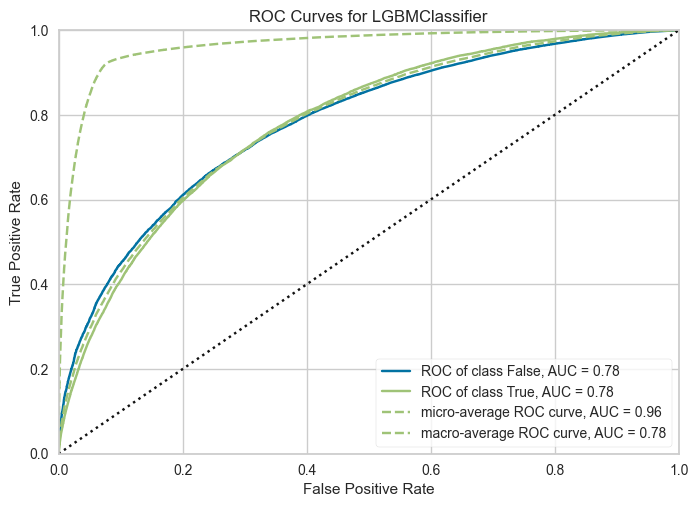

In [34]:
plot_model(lgbm, plot = 'auc')

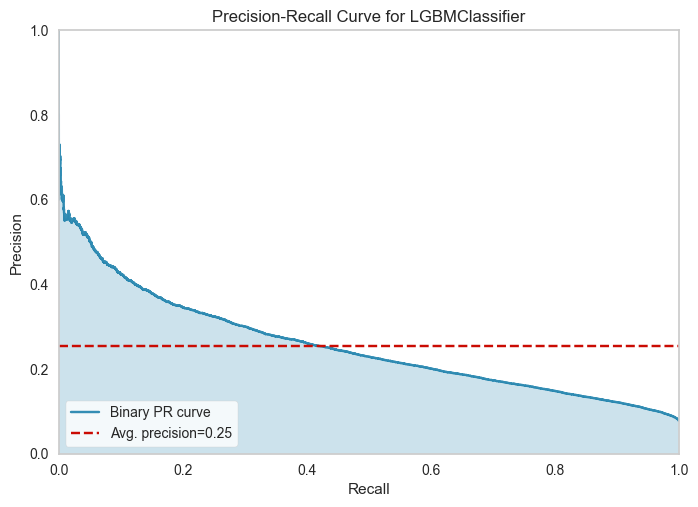

In [35]:
plot_model(lgbm, plot = 'pr')

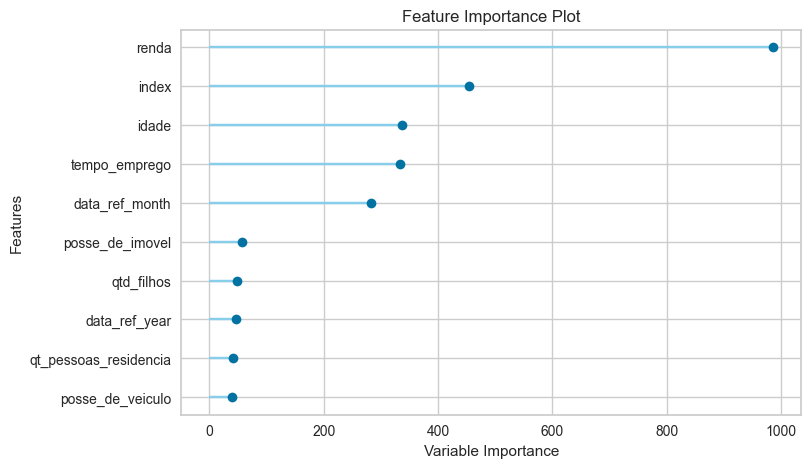

In [36]:
plot_model(lgbm, plot='feature')

In [38]:
final_lgbm = finalize_model(lgbm)

In [39]:
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9224,0.7895,0.0282,0.5833,0.0539,0.0470,0.1160


In [40]:
print(final_lgbm)

Pipeline(memory=FastMemory(location=/var/folders/6x/3y02z1591rj130ytmr_hv8nh0000gn/T/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_em...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,

In [43]:
pickle.dump(final_lgbm, open('model_final.pkl','wb'))